In [7]:
import json
import os
from pathlib import Path
from itertools import permutations

import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, welch
from scipy.stats import skew, kurtosis, pearsonr

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import (
    GroupShuffleSplit,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier



In [8]:
## Mauvaise prediction de la classe 1 pour l'instant
## Regarder pour scaler les trucs pour chaque signal et pas accros tout les samples 
## Cyp affirme que le choix du model et des parametre ne devrait pas faire autant de diff avec le top du leaderbord, c'est qu il nous faut des meilleur feature
## Donne code + papier d'edunao a claude et ameliorer les features
## Utilisation quand on cree les features, je sais pas si y a pas possiblement du dataleakage (mais cela ne devrait pas impacter quand on entraine sur tout le dataset pour la submission)
## Une piste pourrait etre d'utiliser un des 7 signaux (individu) comme test set, parce je crois que la on overfit peut etre trop aux individus que nous on a (et qui ne sont pas dans le test set )

In [9]:
# Set up global variables

# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Load Data and Create Features

In [10]:
# Load data and store it in simple dataframe

def load_data(path):
    signals = {}
    for root, _, files in os.walk(path):
        for file in sorted(files):  # Sort for consistency
            file_path = os.path.join(root, file)
            # Extract the actual signal number from filename (e.g., "signal_8.npy" -> 8)
            signal_num = int(file.split('_')[-1].split('.')[0])
            signals[signal_num] = np.load(file_path)
    return signals

def format_data(train):
    # Define base columns
    base_columns = ['captor_0', 'captor_1', 'captor_2', 'captor_3', 'captor_4', 'num_epoch', 'num_signal']
    
    # Add target column only for training data
    if train:
        columns = base_columns.copy()
        columns.insert(5, 'target')  # Insert target at position 5 (after captors, before num_epoch)
        signals = load_data('signals_train')
        targets = load_data('targets_train')
    else:
        columns = base_columns
        signals = load_data('signals_test')
    
    main_df = pd.DataFrame(columns=columns)

    for signal_idx in signals.keys():
        signal = signals[signal_idx]

        ########### Scale the signal
        signal = (signal - signal.mean(axis=1, keepdims=True)) / (signal.std(axis=1, keepdims=True) + 1e-8)
        
        ###########
        if train:
            target = targets[signal_idx]
        
        # Split signal into chunks of 3000
        splited_signal = np.array_split(signal, np.arange(3000, signal.shape[1], 3000), axis=1)
        
        # Create DataFrame for this signal
        df = pd.DataFrame(
            index=range(len(splited_signal)),
            columns=[f"captor_{i}" for i in range(5)]
        )
        
        # Fill captor data
        for idx, signal_matrix in enumerate(splited_signal):
            for captor in range(signal_matrix.shape[0]):
                df.loc[idx, f"captor_{captor}"] = signal_matrix[captor, :].squeeze()
        
        # Add metadata columns
        df['num_epoch'] = df.index
        df['num_signal'] = signal_idx
        
        # Add target only for training data
        if train:
            df['target'] = target
        
        # Reorder columns to match main_df structure
        df = df[columns]
        
        # Concatenate with main DataFrame
        main_df = pd.concat([main_df, df], ignore_index=True)

    return main_df


In [40]:
# Feature extraction of previous dataframe


# ==========================================
# CELLULE 1 : IMPORTS & FONCTIONS MATHS
# ==========================================
import numpy as np
import pandas as pd
from scipy.signal import welch, hilbert, butter, filtfilt
from scipy.stats import skew, kurtosis
from scipy.linalg import svd
from itertools import permutations

# --- Fonctions Utilitaires ---

def hjorth_params(signal):
    """Activity, Mobility, Complexity."""
    first_deriv = np.diff(signal)
    second_deriv = np.diff(signal, 2)
    var_zero = np.var(signal)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
    complexity = (np.sqrt(var_d2 / var_d1) / mobility) if var_d1 > 0 and mobility > 0 else 0
    return activity, mobility, complexity

def petrosian_fd(signal):
    """Dimension Fractale de Petrosian (Rapidité)."""
    diff = np.diff(signal)
    n_delta = (diff[:-1] * diff[1:] < 0).sum()
    n = len(signal)
    if n_delta == 0: return 1.0
    return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * n_delta)))

def svd_entropy(signal, delay=1, embed_dim=3):
    """Entropie basée sur la décomposition en valeurs singulières."""
    n = len(signal)
    if n < delay * (embed_dim - 1): return 0
    mat = np.array([signal[i : n - (embed_dim - 1 - i) * delay] for i in range(embed_dim)])
    try:
        W = svd(mat, compute_uv=False)
        W /= np.sum(W)
        return -np.sum(W * np.log(W + 1e-12))
    except:
        return 0

def permutation_entropy(signal, order=3, delay=1):
    """(Votre fonction existante conservée)"""
    n = len(signal)
    if n < order * delay: return 0
    perms = list(permutations(range(order)))
    count = {p: 0 for p in perms}
    for i in range(n - delay * (order - 1)):
        # Extraction du pattern simple
        idx = [i + j * delay for j in range(order)]
        segment = signal[idx]
        if len(segment) != order: continue 
        sorted_idx = tuple(np.argsort(segment))
        if sorted_idx in count: count[sorted_idx] += 1
    probs = np.array(list(count.values()))
    probs = probs[probs > 0] / (n - delay * (order - 1))
    return -np.sum(probs * np.log(probs))

def spectral_entropy_custom(psd):
    """Votre spectral_entropy renommé pour éviter conflits"""
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    return -np.sum(psd_norm * np.log(psd_norm + 1e-12))



#####################################################
def add_lagged_features(df, columns_to_lag, lags=[-1, 1], id_col='num_signal'):
    """
    Adds time-shifted versions of specific features, respecting subject boundaries.
    
    Args:
        df: The dataframe containing features.
        columns_to_lag: List of column names to create lags for.
        lags: List of integers. Negative = past (t-1), Positive = future (t+1).
        id_col: Column identifying the subject/recording to prevent data leakage.
    """
    df_out = df.copy()
    
    # We group by subject so that the last epoch of Subject A 
    # doesn't become the "previous" epoch for Subject B.
    grouped = df_out.groupby(id_col)[columns_to_lag]
    
    for shift in lags:
        # Define prefix based on direction
        if shift < 0:
            prefix = f"prev_{abs(shift)}"
        else:
            prefix = f"next_{abs(shift)}"
            
        # Perform the shift
        # Note: shift(-1) in pandas moves data UP (gets next row), which fits logic
        # shift(1) moves data DOWN (gets prev row)
        # We use standard notation: lag -1 means "t-1"
        shifted_data = grouped.shift(shift)
        
        # Rename columns
        shifted_data.columns = [f"{prefix}_{col}" for col in columns_to_lag]
        
        # Concatenate efficiently
        df_out = pd.concat([df_out, shifted_data], axis=1)
    
    # Fill NaN values created at the edges of recordings (start/end)
    # Filling with 0 is standard for tree-based models (XGBoost handles 0/NaN well)
    df_out = df_out.fillna(0)
    
    return df_out









######################################################



# ==========================================
# CELLULE 2 : EXTRACTION DE FEATURES
# ==========================================

def extract_frequency_features(signal, fs=100):
    # Calcul PSD
    freqs, psd = welch(signal, fs=fs, nperseg=min(256, len(signal)))
    total_power = np.sum(psd)
    
    feats = {}
    feats['spectral_entropy'] = float(spectral_entropy_custom(psd))
    
    # Bandes (Inclusion Gamma)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 
             'sigma': (12, 15), 'beta': (13, 30), 'gamma': (30, 49)}
    
    b_pow = {}
    for band, (l, h) in bands.items():
        mask = (freqs >= l) & (freqs <= h)
        val = np.sum(psd[mask]) if np.any(mask) else 0.0
        b_pow[band] = val
        feats[f'{band}_rel'] = val / total_power if total_power > 0 else 0

    # Ratios (Crucial pour N1/N2/N3)
    eps = 1e-8
    feats['r_delta_theta'] = b_pow['delta'] / (b_pow['theta'] + eps)
    feats['r_delta_alpha'] = b_pow['delta'] / (b_pow['alpha'] + eps)
    feats['r_theta_alpha'] = b_pow['theta'] / (b_pow['alpha'] + eps)
    
    # Centre de masse spectral (Mean Frequency)
    feats['spec_mean'] = np.sum(freqs * psd) / (total_power + eps)
    
    return feats

def extract_time_features(signal):
    # Statistiques de base
    return {
        'std': np.std(signal), 'iqr': np.percentile(signal, 75) - np.percentile(signal, 25),
        'skew': skew(signal), 'kurt': kurtosis(signal),
        'rms': np.sqrt(np.mean(signal**2))
    }

def extract_spindle_features(signal, fs=100):
    # Détection d'activité "Bursty" en Sigma (Spindles N2)
    nyq = 0.5 * fs
    b, a = butter(4, [12/nyq, 15/nyq], btype='band')
    try:
        filt = filtfilt(b, a, signal)
        env = np.abs(hilbert(filt))
        return {'sigma_env_std': np.std(env), 'sigma_env_max': np.max(env)}
    except:
        return {'sigma_env_std': 0, 'sigma_env_max': 0}

def extract_channel_features(channel_signal):
    """Fonction MASTER qui appelle tout le reste"""
    fs = 100 # Assurez-vous que c'est bien votre FS
    
    # 1. Temporel Base
    f_time = extract_time_features(channel_signal)
    
    # 2. Fréquentiel (Bandes + Ratios + Entropie)
    f_freq = extract_frequency_features(channel_signal, fs=fs)
    
    # 3. Non-Linéaire & Complexe
    act, mob, comp = hjorth_params(channel_signal)
    f_nonlinear = {
        'hjorth_mob': mob, 
        'hjorth_comp': comp,
        'petrosian': petrosian_fd(channel_signal),
        'svd_entropy': svd_entropy(channel_signal),
        'perm_entropy': permutation_entropy(channel_signal)
    }
    
    # 4. Spécifique Morphologie (Spindles)
    f_morpho = extract_spindle_features(channel_signal, fs=fs)
    
    # Fusion
    return {**f_time, **f_freq, **f_nonlinear, **f_morpho}


def extract_cross_channel_features(channel_signals):
    """Extract features that involve multiple channels."""
    features = {}
    
    # Correlations between channel pairs
    for i in range(NUM_CHANNELS):
        for j in range(i+1, NUM_CHANNELS):
            corr, _ = pearsonr(channel_signals[i], channel_signals[j])
            features[f'corr_ch{i}_ch{j}'] = float(corr)
    
    # Spatial variability
    channel_stds = [np.std(signal) for signal in channel_signals]
    features['spatial_std'] = float(np.std(channel_stds))
    features['spatial_mean_std'] = float(np.mean(channel_stds))
    
    return features

def add_temporal_context(features_df, window=3):
    """Add rolling statistics to capture temporal patterns."""
    # Add rolling statistics for key features
    key_features = ['ch0_delta_power', 'ch0_alpha_power', 'ch0_sigma_power']
    
    for col in key_features:
        if col in features_df.columns:
            # Rolling statistics within each signal
            for signal_id in features_df['num_signal'].unique():
                mask = features_df['num_signal'] == signal_id
                
                # Rolling mean
                rolling_mean = features_df.loc[mask, col].rolling(window, center=True).mean()
                features_df.loc[mask, f'{col}_roll_mean_{window}'] = rolling_mean
                
                # Rolling std
                rolling_std = features_df.loc[mask, col].rolling(window, center=True).std()
                features_df.loc[mask, f'{col}_roll_std_{window}'] = rolling_std
                
                # Difference from previous epoch
                features_df.loc[mask, f'{col}_diff_{window}'] = features_df.loc[mask, col].diff()
    
    # Fill NaN values
    features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)
    
    return features_df

def process_single_epoch(row):
    """Process a single epoch (row) to extract all features."""
    features = {}
    
    # Process each channel
    channel_signals = []
    for ch in range(NUM_CHANNELS):
        # Get signal for this channel
        signal = np.array(row[f'captor_{ch}'])
        
        # Ensure correct length
        if len(signal) != SAMPLES_PER_EPOCH:
            if len(signal) < SAMPLES_PER_EPOCH:
                signal = np.pad(signal, (0, SAMPLES_PER_EPOCH - len(signal)), mode='constant')
            else:
                signal = signal[:SAMPLES_PER_EPOCH]
        
        # Extract channel features
        ch_features = extract_channel_features(signal)
        
        # Add channel prefix to feature names
        for key, value in ch_features.items():
            features[f'ch{ch}_{key}'] = value
        
        channel_signals.append(signal)
    
    # Extract cross-channel features
    cross_features = extract_cross_channel_features(channel_signals)
    features.update(cross_features)
    
    # Add metadata
    features['num_epoch'] = int(row['num_epoch'])
    features['num_signal'] = int(row['num_signal'])
    
    return features


def create_features_parallel(df):
    print(f"Processing {len(df)} epochs in parallel...")
    
    # 1. Extraction (Parallel)
    results = Parallel(n_jobs=-1)(
        delayed(process_single_epoch)(row) for _, row in df.iterrows()
    )
    features_df = pd.DataFrame(results)
    
    # 2. Define Key Features for Temporal Context
    # We focus on the most discriminative features for sleep stages
    # (Delta = Deep sleep, Alpha = Awake, Sigma = N2, Entropy = REM/N1)
    # We look for columns ending in these suffixes for Channel 0 (usually the cleanest)
    important_suffixes = ['delta_rel', 'alpha_rel', 'sigma_rel', 'spectral_entropy', 'sigma_env_std']
    
    cols_to_lag = [c for c in features_df.columns if any(s in c for s in important_suffixes)]
    
    # Ensure we limit to specific channels if you have many (e.g., only ch0 and ch1)
    # This prevents creating 5000 columns if you have 20 channels
    cols_to_lag = [c for c in cols_to_lag if 'ch0' in c or 'ch1' in c]

    print(f"Generating Lag features for {len(cols_to_lag)} key columns...")

    # 3. Add Lag Features (t-1, t+1, t-2, t+2)
    # Immediate context (1 epoch = 30s)
    features_df = add_lagged_features(
        features_df, 
        cols_to_lag, 
        lags=[-1, 1, -2, 2], 
        id_col='num_signal'
    )
    
    # 4. Add Rolling Statistics (Your existing function)
    # Rolling stats capture "trends" (e.g., "is delta power increasing over the last 5 mins?")
    print("Adding rolling temporal context...")
    features_df = add_temporal_context(features_df, window=5) # Short trend
    features_df = add_temporal_context(features_df, window=50)
    features_df = add_temporal_context(features_df, window=500) 

    return features_df

In [12]:
# # Test new feature extraction Gemini

# import numpy as np
# from scipy.signal import welch
# from scipy.stats import skew, kurtosis

# # ==========================================
# # 1. Ajout de la bande Gamma et des Ratios
# # ==========================================
# def extract_frequency_features(signal, fs=100):
#     """
#     Extrait les features fréquentielles incluant la bande Gamma 
#     et des ratios spectraux pertinents.
#     """
#     features = {}
    
#     # Calcul du PSD avec Welch
#     freqs, psd = welch(signal, fs=fs, nperseg=min(256, len(signal)))
#     total_power = np.sum(psd)

#     # ---------- GLOBAL SPECTRAL ENTROPY ----------
#     # (Votre fonction spectral_entropy existante)
#     features['spectral_entropy'] = float(spectral_entropy(psd))

#     # Définition des bandes (Ajout de GAMMA) [cite: 1, 2]
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'sigma': (12, 15),
#         'beta': (13, 30),
#         'gamma': (30, 49) # La fréquence d'échantillonnage est 100Hz, Nyquist est 50Hz
#     }

#     band_powers = {}

#     # ---------- BAND FEATURES ----------
#     for band_name, (low, high) in bands.items():
#         band_mask = (freqs >= low) & (freqs <= high)
#         if np.any(band_mask):
#             val = np.sum(psd[band_mask])
#         else:
#             val = 0.0
        
#         band_powers[band_name] = val
#         features[f'{band_name}_power'] = float(val)
#         features[f'{band_name}_rel_power'] = float(val / total_power if total_power > 0 else 0)

#     # ---------- SPECTRAL RATIOS ----------
#     # Ces ratios aident souvent à distinguer le sommeil profond (Delta dominant) de l'éveil/REM
#     epsilon = 1e-8
#     features['ratio_delta_theta'] = band_powers['delta'] / (band_powers['theta'] + epsilon)
#     features['ratio_delta_alpha'] = band_powers['delta'] / (band_powers['alpha'] + epsilon)
#     features['ratio_delta_beta']  = band_powers['delta'] / (band_powers['beta'] + epsilon)
#     features['ratio_theta_alpha'] = band_powers['theta'] / (band_powers['alpha'] + epsilon)
    
#     # Spectral Edge Frequency 95%
#     cumsum_psd = np.cumsum(psd)
#     if len(cumsum_psd) > 0 and cumsum_psd[-1] > 0:
#         sef_idx = np.where(cumsum_psd >= 0.95 * cumsum_psd[-1])[0]
#         features['sef95'] = float(freqs[sef_idx[0]] if len(sef_idx) > 0 else 0)
#     else:
#         features['sef95'] = 0.0

#     features['total_power'] = float(total_power)
#     return features

# # ==========================================
# # 2. Nouvelles Features Non-Linéaires & Temporelles
# # ==========================================
# def higuchi_fd(signal, kmax=10):
#     """Calcule la dimension fractale de Higuchi (complexité)."""
#     L = []
#     x = []
#     N = len(signal)
#     for k in range(1, kmax):
#         Lk = []
#         for m in range(0, k):
#             Lmk = 0
#             for i in range(1, int(np.floor((N - m) / k))):
#                 Lmk += abs(signal[m + i * k] - signal[m + (i - 1) * k])
#             Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
#             Lk.append(Lmk)
#         L.append(np.log(np.mean(Lk)))
#         x.append([np.log(1.0/ k), 1])
    
#     # Fit linéaire pour trouver la pente
#     (p, _) = np.linalg.lstsq(x, L, rcond=None)[0]
#     return p

# def hjorth_params(signal):
#     """Calcule les paramètres de Hjorth: Activity, Mobility, Complexity."""
#     first_deriv = np.diff(signal)
#     second_deriv = np.diff(signal, 2)

#     var_zero = np.var(signal)
#     var_d1 = np.var(first_deriv)
#     var_d2 = np.var(second_deriv)

#     activity = var_zero
#     mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
#     complexity = (np.sqrt(var_d2 / var_d1) / mobility) if var_d1 > 0 and mobility > 0 else 0

#     return activity, mobility, complexity

# def extract_advanced_time_features(signal):
#     """
#     Ajoute les features avancées recommandées par la littérature (Entropy 2016).
#     """
#     features = {}
    
#     # --- Hjorth Parameters  ---
#     act, mob, comp = hjorth_params(signal)
#     features['hjorth_activity'] = float(act)
#     features['hjorth_mobility'] = float(mob)
#     features['hjorth_complexity'] = float(comp)
    
#     # --- Zero Crossing Rate  ---
#     # Centrer le signal avant de compter les passages par zéro
#     signal_centered = signal - np.mean(signal)
#     zcr = ((signal_centered[:-1] * signal_centered[1:]) < 0).sum()
#     features['zero_crossing_rate'] = float(zcr) / len(signal)
    
#     # --- Higuchi Fractal Dimension  ---
#     # Note: kmax=10 est une valeur standard pour l'EEG
#     try:
#         features['higuchi_fd'] = float(higuchi_fd(signal, kmax=10))
#     except:
#         features['higuchi_fd'] = 0.0

#     return features

# # ==========================================
# # 3. Mise à jour de la fonction extract_channel_features
# # ==========================================
# def extract_channel_features(channel_signal):
#     """Combine toutes les extractions pour un canal."""
#     # Features temporelles de base (votre fonction existante)
#     time_features = extract_time_features(channel_signal)
    
#     # Features fréquentielles (Mise à jour avec Gamma + Ratios)
#     freq_features = extract_frequency_features(channel_signal, fs=SAMPLING_RATE)
    
#     # Features avancées (Hjorth, ZCR, FD)
#     adv_features = extract_advanced_time_features(channel_signal)

#     # Permutation entropy (votre fonction existante)
#     # Le papier cite aussi "Permutation entropy" comme feature non-linéaire utile 
#     pe = float(permutation_entropy(channel_signal, order=3, delay=1))
    
#     # Fusionner tout
#     all_features = {**time_features, **freq_features, **adv_features}
#     all_features['permutation_entropy'] = pe
    
#     return all_features


# from scipy.signal import hilbert, butter, filtfilt
# from scipy.linalg import svd

# # ==========================================
# # 4. Features de Morphologie et Complexité Avancée
# # ==========================================

# def petrosian_fd(signal):
#     """
#     Dimension Fractale de Petrosian.
#     Plus rapide que Higuchi, elle mesure la 'rugosité' du signal via les changements de signe de la dérivée.
#     Pertinent pour : Éveil vs NREM.
#     """
#     diff = np.diff(signal)
#     # Nombre de changements de signe dans la dérivée
#     n_delta = (diff[:-1] * diff[1:] < 0).sum()
#     n = len(signal)
#     if n_delta == 0:
#         return 1.0
#     return np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * n_delta)))

# def svd_entropy(signal, delay=1, embed_dim=3):
#     """
#     Entropie SVD (Singular Value Decomposition).
#     Mesure la complexité du signal en reconstruisant un espace de phase.
#     Pertinent pour : REM vs N1/Éveil.
#     """
#     # Création de la matrice de trajectoire (Embedding)
#     n = len(signal)
#     if n < delay * (embed_dim - 1):
#         return 0
    
#     # Matrice retardée
#     mat = np.array([signal[i : n - (embed_dim - 1 - i) * delay] 
#                     for i in range(embed_dim)])
    
#     # Valeurs singulières
#     try:
#         W = svd(mat, compute_uv=False)
#         W /= np.sum(W)  # Normalisation
#         return -np.sum(W * np.log(W + 1e-12))
#     except:
#         return 0

# def spectral_moments(freqs, psd):
#     """
#     Calcule le centre de masse (Mean Freq) et la dispersion (Bandwidth) du spectre.
#     Pertinent pour : Changements globaux du spectre (ex: ralentissement en sommeil profond).
#     """
#     psd_sum = np.sum(psd)
#     if psd_sum == 0:
#         return 0, 0
    
#     # Moyenne pondérée (Spectral Centroid)
#     mean_freq = np.sum(freqs * psd) / psd_sum
    
#     # Écart-type spectral (Spectral Bandwidth)
#     bandwidth = np.sqrt(np.sum(((freqs - mean_freq) ** 2) * psd) / psd_sum)
    
#     return mean_freq, bandwidth

# def sigma_spindle_feature(signal, fs=100):
#     """
#     Mesure la variabilité de l'enveloppe dans la bande Sigma (12-15 Hz).
#     Une variance élevée indique la présence de 'bursts' (fuseaux), typiques du stade N2.
#     """
#     # Filtre passe-bande Sigma (12-15 Hz)
#     nyq = 0.5 * fs
#     low = 12 / nyq
#     high = 15 / nyq
#     b, a = butter(4, [low, high], btype='band')
    
#     try:
#         filtered = filtfilt(b, a, signal)
#         # Transformée de Hilbert pour obtenir l'enveloppe
#         envelope = np.abs(hilbert(filtered))
        
#         # Features de l'enveloppe
#         return {
#             'sigma_env_mean': float(np.mean(envelope)),
#             'sigma_env_std': float(np.std(envelope)),  # Indicateur clé de présence de fuseaux
#             'sigma_env_max': float(np.max(envelope))
#         }
#     except:
#         return {'sigma_env_mean': 0, 'sigma_env_std': 0, 'sigma_env_max': 0}
    



# def extract_channel_features(channel_signal):
#     """Combine TOUTES les extractions pour un canal."""
    
#     # 1. Temporelles de base
#     time_features = extract_time_features(channel_signal)
    
#     # 2. Fréquentielles (avec les bandes mises à jour précédemment)
#     freq_features = extract_frequency_features(channel_signal, fs=SAMPLING_RATE)
    
#     # 3. Avancées (Hjorth, ZCR, Higuchi - du message précédent)
#     adv_features = extract_advanced_time_features(channel_signal)
    
#     # --- NOUVEAUX AJOUTS ---
    
#     # 4. Dimension Fractale Petrosian (Rapide)
#     pfd = petrosian_fd(channel_signal)
    
#     # 5. SVD Entropy
#     svd_en = svd_entropy(channel_signal)
    
#     # 6. Moments Spectraux (Besoin de re-calculer PSD ou récupérer de freq_features si adapté)
#     # Pour faire simple, on recalcule rapidement ici ou on modifie extract_frequency_features
#     # Utilisons welch localement pour être indépendant
#     f_ax, psd_val = welch(channel_signal, fs=SAMPLING_RATE, nperseg=min(256, len(channel_signal)))
#     spec_mean, spec_bw = spectral_moments(f_ax, psd_val)
    
#     # 7. Détection Spindle (Sigma Envelope)
#     spindle_feats = sigma_spindle_feature(channel_signal, fs=SAMPLING_RATE)

#     # Fusion
#     extra_features = {
#         'petrosian_fd': float(pfd),
#         'svd_entropy': float(svd_en),
#         'spectral_mean': float(spec_mean),
#         'spectral_bandwidth': float(spec_bw),
#         **spindle_feats
#     }
    
#     # Permutation entropy existante
#     pe = float(permutation_entropy(channel_signal, order=3, delay=1))
    
#     # Tout combiner
#     all_features = {
#         **time_features, 
#         **freq_features, 
#         **adv_features, 
#         **extra_features,
#         'permutation_entropy': pe
#     }
    
#     return all_features





In [13]:
# Create the submission file

def create_submission(df_test, predictions, file_name = ''):
    # num_signal already contains the correct signal numbers
    identifiers = df_test['num_signal'] * 10000 + df_test['num_epoch']
    
    submission = pd.DataFrame({
        'identifier': identifiers.astype(int),
        'target': predictions.astype(int)
    })
    
    submission = submission.sort_values('identifier').reset_index(drop=True)
    submission.to_csv(file_name + 'submission.csv', index=False)

    # Check wether everything wnt well while creating the submission file
    df_ok = pd.read_csv('sample.csv')
    set1 = set(submission.identifier)
    set2 = set(df_ok.identifier)
    difference = set1.symmetric_difference(set2)
    print('labels that are not in boths sets : ', difference)
    
    return submission

## Data exploration

In [41]:
df = format_data(True)
df_features = create_features_parallel(df)

Processing 7433 epochs in parallel...
Generating Lag features for 10 key columns...
Adding rolling temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_15660\1920310286.py:246: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


In [42]:
# ==========================================
# CELLULE 3 : PRE-PROCESSING AVANCÉ
# ==========================================

def prepare_advanced_data(df, feature_cols, id_col='num_signal'):
    df_proc = df.copy()
    
    print("1. Normalisation Z-Score par Sujet...")
    # On normalise chaque sujet indépendamment pour éliminer les biais d'amplitude perso
    df_proc[feature_cols] = df_proc.groupby(id_col)[feature_cols].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )
    
    print("2. Ajout du Contexte Temporel (Lag/Lead)...")
    # On ajoute t-1 et t+1 pour donner du contexte au modèle
    # (Le sommeil est une séquence, pas des points isolés)
    shifts = [-1, 1] 
    
    # Pour ne pas exploser la mémoire, on le fait sur les features clés
    # Si vous avez assez de RAM, mettez 'feature_cols' à la place de 'key_features'
    key_features = [c for c in feature_cols if 'delta' in c or 'sigma' in c or 'entropy' in c]
    
    for shift in shifts:
        direction = "prev" if shift < 0 else "next"
        shifted = df_proc.groupby(id_col)[key_features].shift(-shift)
        shifted.columns = [f"{direction}_{c}" for c in key_features]
        df_proc = pd.concat([df_proc, shifted], axis=1)
    
    # Remplir les NaN créés aux bords (début/fin d'enregistrement)
    df_proc = df_proc.fillna(0)
    
    return df_proc


X_df, y = df_features, df['target'].astype(int)

# --- EXECUTION ---
# Assurez-vous que X_df contient encore 'series_id' à ce stade !
# Si series_id est dans un autre df, concaténez-le temporairement.

# Exemple d'utilisation :
X_processed = prepare_advanced_data(X_df, X_df.columns, id_col='num_signal')

# Mettez à jour vos X et y finaux
X = X_processed.drop(columns=['num_signal'])




1. Normalisation Z-Score par Sujet...
2. Ajout du Contexte Temporel (Lag/Lead)...


In [29]:
X_processed.head()

,ch0_std,ch0_iqr,ch0_skew,ch0_kurt,ch0_rms,ch0_spectral_entropy,ch0_delta_rel,ch0_theta_rel,ch0_alpha_rel,ch0_sigma_rel,...,next_ch3_sigma_env_max,next_ch4_spectral_entropy,next_ch4_delta_rel,next_ch4_sigma_rel,next_ch4_r_delta_theta,next_ch4_r_delta_alpha,next_ch4_svd_entropy,next_ch4_perm_entropy,next_ch4_sigma_env_std,next_ch4_sigma_env_max
0,-0.538912,-0.375401,0.458869,-0.501953,-0.539091,1.147371,-2.694797,-0.048886,5.146451,1.296381,...,-0.132215,1.393143,-0.666689,1.147414,-0.512593,-0.450248,1.693916,0.578848,-0.279484,-0.405872
1,-0.592768,-0.457407,0.537545,-0.488895,-0.592939,1.073544,-2.656028,-0.270431,5.060411,0.760345,...,-0.163086,1.318554,-1.565143,1.291469,-0.552962,-0.454196,1.693158,0.298594,-0.262444,-0.365689
2,-0.623528,-0.517660,0.373790,-0.527890,-0.623694,1.220291,-2.307182,-0.006914,4.440098,0.542008,...,-0.259694,1.492472,-1.366503,1.382405,-0.550613,-0.453681,1.807388,0.673037,-0.341098,-0.365825
3,-0.641015,-0.533614,0.530217,-0.498499,-0.641174,1.117110,-2.542856,-0.229468,4.866849,0.945684,...,-0.232302,1.535934,-1.353561,1.119274,-0.551699,-0.453554,1.816234,0.629034,-0.318509,-0.368908
4,-0.642672,-0.571651,0.536131,-0.473473,-0.642823,1.165406,-1.867465,-0.026811,4.072900,0.793355,...,-0.224686,1.455874,-1.699123,1.284016,-0.559861,-0.455746,1.846180,0.178051,-0.330953,-0.411515


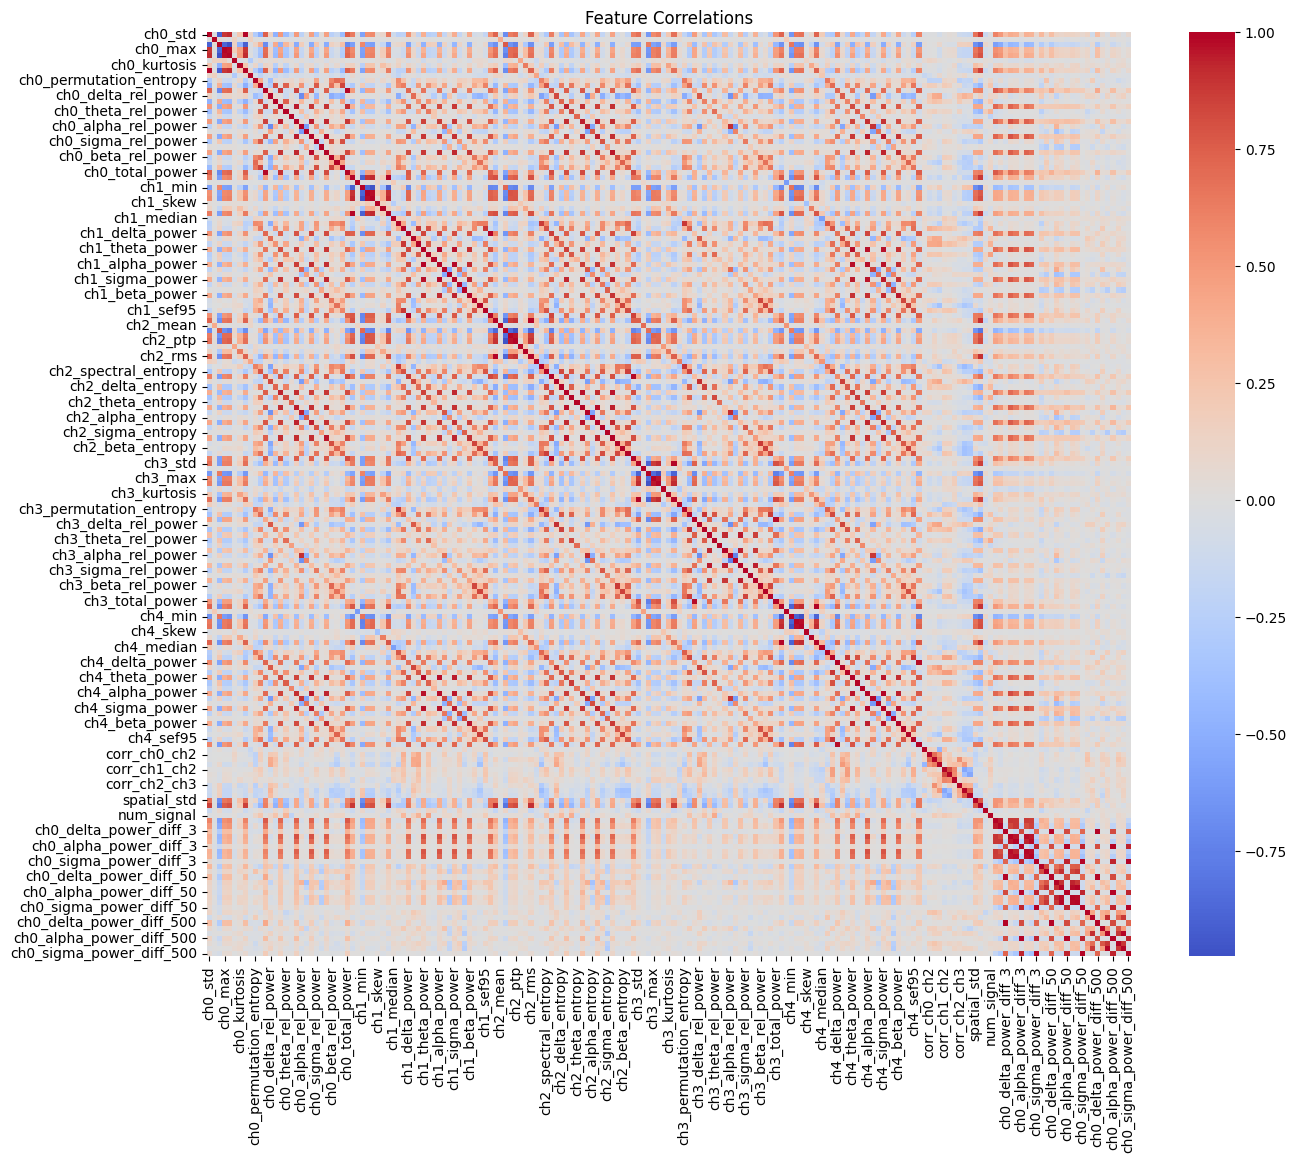

In [ ]:
## Pas tres travaille pour l'instant, je voulais voir les correls et enlever ce qui est trop correle mais dure de faire de la feature selection

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
corr_matrix = df_features.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlations')
plt.show()

# Find highly correlated pairs (> 0.8 or <-0.8)
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr))

## Build Model

### XGBoost models

In [43]:
# XGboost model train

# X_df, y = df_features.drop(['num_signal'], axis=1), df['target'].astype(int)


# 1. Split 
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=12)


# 2. Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


sample_weights = compute_sample_weight('balanced', y_train)

model = XGBClassifier(
    n_estimators=500,
    max_depth=7,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=12
)

model.fit(X_train, y_train, sample_weight=sample_weights)
predictions = model.predict(X_test)

from scipy.signal import medfilt

def smooth_predictions(predictions, window_size=3):
    """Lisse les prédictions pour éviter les sauts rapides irréalistes."""
    # Le filtre médian remplace une valeur par la médiane de ses voisins
    return medfilt(predictions, kernel_size=window_size)



f1_macro = f1_score(y_test, predictions, average='macro')
f1_micro = f1_score(y_test, predictions, average='micro')
f1_per_class = f1_score(y_test, predictions, average=None)

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (micro): {f1_micro:.4f}")
for i, score in enumerate(f1_per_class):
    print(f"Class {i} F1 Score: {score:.4f}")

F1 Score (macro): 0.8685
F1 Score (micro): 0.9132
Class 0 F1 Score: 0.9165
Class 1 F1 Score: 0.6054
Class 2 F1 Score: 0.9328
Class 3 F1 Score: 0.9522
Class 4 F1 Score: 0.9354


In [ ]:
'''F1 Score (macro): 0.8661
F1 Score (micro): 0.9126
Class 0 F1 Score: 0.9118
Class 1 F1 Score: 0.5876
Class 2 F1 Score: 0.9330
Class 3 F1 Score: 0.9524
Class 4 F1 Score: 0.9458'''

In [45]:
## Create submission, so we use whole dataset for training

X_df, y = df_features.drop(['num_signal'], axis=1), df['target']
df_test = format_data(False)
X_test = create_features_parallel(df_test).drop(['num_signal'], axis=1)


# 2. Scale second
scaler = StandardScaler()
X_train = scaler.fit_transform(X_df)
X_test = scaler.transform(X_test)



# Model that performed best for now
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,  # Deeper for complex patterns
    learning_rate=0.05,  # Lower for better generalization
    reg_lambda=1.0,  # L2 regularization
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=RANDOM_STATE
)



model.fit(X_train, y.astype(int))
predictions = model.predict(X_test)


from scipy.signal import medfilt

def smooth_predictions(predictions, window_size=5):
    """Lisse les prédictions pour éviter les sauts rapides irréalistes."""
    # Le filtre médian remplace une valeur par la médiane de ses voisins
    return medfilt(predictions, kernel_size=window_size)


pred = smooth_predictions(predictions)


create_submission(df_test, pred, "less_param")

Processing 4077 epochs in parallel...
Generating Lag features for 10 key columns...
Adding rolling temporal context...


C:\Users\mathias\AppData\Local\Temp\ipykernel_15660\1920310286.py:246: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df = features_df.fillna(method='bfill').fillna(method='ffill').fillna(0)


labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
# Create a submission for simple random forest
## This showed us that all the models perform similarly, so we need one more good feature probably to be well ranked in the leaderbord

rf = RandomForestClassifier(
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2, 
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)


rf.fit(X_train, y.astype(int))
predictions = rf.predict(X_test)

create_submission(df_test, predictions, 'rf_')

labels that are not in boths sets :  set()


,identifier,target
0,80000,0
1,80001,2
2,80002,2
3,80003,2
4,80004,2
...,...,...
4072,110913,0
4073,110914,0
4074,110915,0
4075,110916,0


In [ ]:
## Same for SVM that performs similarly to the other models
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM with custom class weights
svm = SVC(
    kernel='rbf',  # or 'linear', 'poly'
    C=1.0,
    gamma='scale',
    class_weight={0: 1, 1: 6, 2: 1, 3: 1, 4: 1},  # Boost class 1
    random_state=42,
    probability=False  # Enable if you need predict_proba
)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_per_class = f1_score(y_test, y_pred, average=None)

print(f"\nTest Set Results:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print("\nPer-class F1 Scores:")
for class_idx, score in enumerate(f1_per_class):
    print(f"  Class {class_idx}: {score:.4f}")


Test Set Results:
F1 Macro: 0.8279
F1 Weighted: 0.8745

Per-class F1 Scores:
  Class 0: 0.8720
  Class 1: 0.5442
  Class 2: 0.9062
  Class 3: 0.9346
  Class 4: 0.8824
